<a href="https://colab.research.google.com/github/hitomitsu50/SportsData_Portfolio/blob/main/2024%E5%B9%B4_MLB_Statcast_%E3%82%B9%E3%82%AF%E3%83%90%E3%83%AB%E7%90%83%E7%A8%AE%E5%B9%B3%E5%9D%87%E9%80%9F%E5%BA%A6_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
#2025年11月9日
#必要なライブラリのインストール
!pip install pybaseball japanize_matplotlib
!sudo apt-get -y install fonts-ipaexfont-gothic
!sudo apt-get -y install fonts-ipaexgont-mincho
!sudo fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipaexfont-gothic is already the newest version (00401-3ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package fonts-ipaexgont-mincho
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/ipaexfont-gothic: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 1 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such di

In [26]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import time
from pybaseball import statcast

In [27]:
#日本語フォントの設定
plt.rcParams["font.family"]="sans-serif"
plt.rcParams["font.sans-serif"]=["IPAexGothic"]
#plt.rcParams["axes.unicode_minus"]=False #負号の表示が必要なら有効化

In [28]:
#CSVファイルの読み込みと結合(sample_dataフォルダ内)
import glob

In [29]:
#ファイル名パターンに一致するCSVを取得（例：statcast_2024-03.csv など）
csv_files_pattern="sample_data/statcast_*.csv"
csv_files=glob.glob(csv_files_pattern)
#読み込んだDataFrameを格納するリスト
dfs=[]
#各csvファイルを読み込み
for file in csv_files:
  try:
    df_month=pd.read_csv(file)
    dfs.append(df_month)
    print(f"[file]を読み込みました")
  except Exception as e:
    print(f"[file]の読み込み中にエラーが発生しました:{e}")

[file]を読み込みました
[file]を読み込みました
[file]を読み込みました
[file]を読み込みました
[file]を読み込みました
[file]を読み込みました
[file]を読み込みました


In [30]:
#全てのデータフレームを結合
if dfs:
  df_combined=pd.concat(dfs, ignore_index=True)
  df=df_combined #メインの変数としてdfに代入
  print("全てのデータフレームを結合しました")
  display(df.head())#先頭５行を表示
  print(f"結合後のデータフレームの行数: {len(df)}")
else:
  print("読み込めるCSVファイルが見つかりませんでした")

全てのデータフレームを結合しました


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,ST,2024-06-30,82.4,-3.63,4.42,"Sewald, Paul",680869,623149,strikeout,called_strike,...,2.0,2.68,-1.28,-1.28,15.8,NaN,NaN,NaN,NaN,NaN
1,ST,2024-06-30,82.2,-3.70,4.35,"Sewald, Paul",680869,623149,NaN,foul,...,2.0,2.78,-1.26,-1.26,16.6,19.691472,-13.003297,35.999290,42.538496,37.741756
2,FF,2024-06-30,90.8,-3.55,4.54,"Sewald, Paul",680869,623149,NaN,foul,...,2.0,1.50,0.81,0.81,16.6,14.876329,3.342341,30.357166,37.709934,27.167091
3,ST,2024-06-30,83.4,-3.64,4.40,"Sewald, Paul",680869,623149,NaN,ball,...,2.0,2.49,-1.45,-1.45,15.3,NaN,NaN,NaN,NaN,NaN
4,FF,2024-06-30,89.9,-3.53,4.45,"Sewald, Paul",680869,623149,NaN,foul,...,2.0,1.86,0.68,0.68,19.2,10.061360,12.153604,30.257349,43.514080,22.018539


結合後のデータフレームの行数: 729481


In [31]:
#1.定数設定
#スクバル（2024年最多勝投手）の各種平均速度
PITCHER_ID=669373 #Tarik Skubal
MIN_PITCHES=50   #投球数が少ない球種は除外
#2.データのフィルタリング
#1) ターゲット投手のデータに絞る
df_strider=df[df["pitcher"]==PITCHER_ID].copy()
#2) release_speedがNaNの投球を除外
df_clean=df_strider.dropna(subset=["release_speed","pitch_type"]).copy()
#3.球種ごとの集計（平均速度と投球数）
pitch_summary=df_clean.groupby("pitch_type").agg(
    avg_speed=("release_speed","mean"),
    pitch_count=("pitch_type","size")
).reset_index()
#4.投球数フィルタリング
pitch_summary=pitch_summary[pitch_summary["pitch_count"]>=MIN_PITCHES]
pitch_summary=pitch_summary.sort_values(by="avg_speed",ascending=False)
print("\n--- [集計結果] スペンサー・ストライダー(2023) 球種別 平均速度と投球数---")
print(pitch_summary.to_markdown(index=False)) #Markdown形式で結果を表示


--- [集計結果] スペンサー・ストライダー(2023) 球種別 平均速度と投球数---
| pitch_type   |   avg_speed |   pitch_count |
|:-------------|------------:|--------------:|
| FF           |     96.8396 |           974 |
| SI           |     96.6003 |           601 |
| SL           |     88.7271 |           436 |
| CH           |     86.2991 |           786 |
| CU           |     78.5282 |           124 |


/tmp/ipython-input-782152567.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


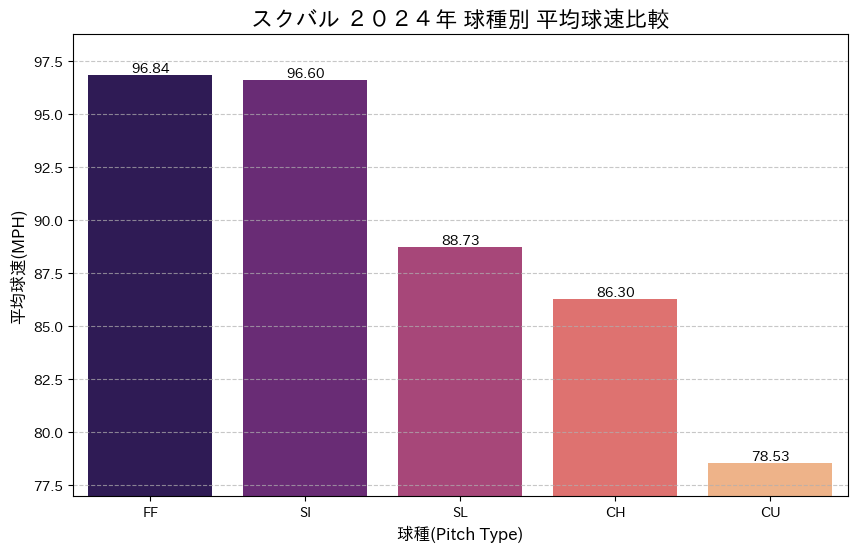

In [35]:
# グラフの可視化（棒グラフ）- 新しいセル
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

plt.figure(figsize=(10,6))
ax = sns.barplot(
    x="pitch_type",
    y="avg_speed",
    data=pitch_summary,
    palette="magma"
)

#グラフの装飾
plt.title("スクバル ２０２４年 球種別 平均球速比較", fontsize=16)
plt.xlabel("球種(Pitch Type)", fontsize=12)
plt.ylabel("平均球速(MPH)", fontsize=12)
plt.ylim(pitch_summary["avg_speed"].min()*0.98, pitch_summary["avg_speed"].max() * 1.02)
plt.grid(axis="y", linestyle="--",alpha=0.7)

# 棒の上に平均球速値を表示
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', color='black', fontsize=10) # fmtを修正

plt.show()